# MNIST Digit Recognition with higher accuracy using Elastic Distortion

## Imports

In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from tempfile import TemporaryDirectory

device = torch.device('cuda')
%config InlineBackend.figure_format = "retina"
writer = SummaryWriter('runs/tbx1')

In [2]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_data.shape, test_data.shape

((42000, 785), (28000, 784))

## Preparing Dataset

In [5]:
X = train_data.values[:, 1:]
y = train_data.values[:, 0]
X.shape, y.shape

((42000, 784), (42000,))

In [6]:
def imshow(images, labels=None):
    fig, axes = plt.subplots(1, len(images))
    for i, img in enumerate(images):
        if labels is not None:
            axes[i].set_title(f'{labels[i]}')
        axes[i].imshow(img, cmap='gray')
        axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

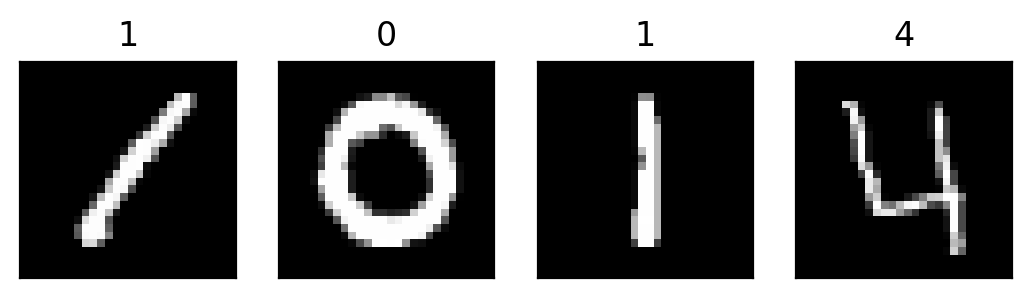

In [7]:
imshow(X[:4, :].reshape(4, 28, 28), y[:4])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [9]:
class MNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.n_samples = X.shape[0]
        X = X.reshape(-1, 28, 28) / 256.
        self.x_data = torch.from_numpy(X.astype(np.float32))
        self.y_data = torch.from_numpy(y)
        
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, item):
        sample = self.x_data[item], self.y_data[item]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

## Transformations

In [10]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

In [11]:
batch_size = 8
num_epochs = 10
num_classes = 10 

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

steps_per_epoch = len(train_loader)
steps_per_epoch

4200

In [13]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([8, 28, 28]), torch.Size([8]))

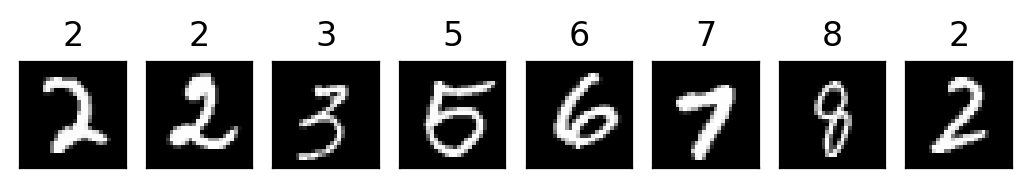

In [14]:
imshow(images, labels)

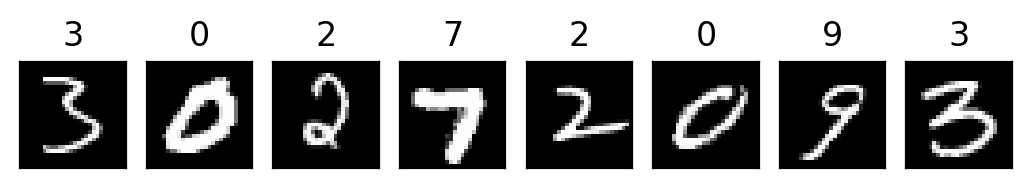

In [15]:
images, labels = next(iter(val_loader))
imshow(images, labels)

## Training Models

In [16]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=num_epochs):
    for epoch in range(num_epochs):

        running_loss = 0.0
            
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)            
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
                     
            writer.add_scalar('loss', loss, i + epoch*steps_per_epoch)
            running_loss += loss

        
        loss = running_loss / steps_per_epoch
        print(f'epoch {epoch+1}/{num_epochs} loss {loss:.4f}')
                
        if scheduler is not None:
            scheduler.step()
            
def validate_model(model, test_loader):
    
    n_samples = 0
    n_correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images) 
            _, predictions = torch.max(output, 1)
            
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()            
            
    acc = n_correct/n_samples * 100
    print(f'Accuracy = {acc:.4}%')
    return acc

In [17]:
class LinearNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

## Comparing Results of Different Models and optimizers

In [18]:
lr = 1e-3
model = LinearNet(28*28).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_model(model, criterion, optimizer, num_epochs=10)

epoch 1/10 loss 0.4295
epoch 2/10 loss 0.2921
epoch 3/10 loss 0.2733
epoch 4/10 loss 0.2626
epoch 5/10 loss 0.2557
epoch 6/10 loss 0.2500
epoch 7/10 loss 0.2450
epoch 8/10 loss 0.2417
epoch 9/10 loss 0.2382
epoch 10/10 loss 0.2368


In [19]:
validate_model(model, val_loader)

Accuracy = 92.14%


92.14285714285714

In [20]:
writer.flush()